# New York Times API Query 
API key credentials is established and NYT API is queried to fetch relevant articles that contain keywords 'Automation, Technology, Robotics'. Then each article is parsed and has its data split into respective fields and stored in a JSON.

In [1]:
import requests
import time
import json

def fetch_articles(api_key, query, total_articles=100):
    base_url = 'https://api.nytimes.com/svc/search/v2/articlesearch.json'
    articles = []
    page_limit = (total_articles // 10) + 1  # Calculate the number of pages to fetch

    for page in range(page_limit):
        params = {
            'q': query,
            'api-key': api_key,
            'page': page
        }
        response = requests.get(base_url, params=params)
        if response.status_code == 200:
            data = response.json()
            articles.extend(data['response']['docs'])
            if len(data['response']['docs']) < 10:
                break  # Exit the loop if fewer than 10 articles are returned
            time.sleep(12)  # Wait for 12 seconds to avoid hitting rate limit
        else:
            print("Failed to fetch data:", response.status_code)
            break

    return articles

api_key = 'YOUR_NYT_API_KEY'
query = 'Automation, Technology, Robotics'

# Fetch articles
articles = fetch_articles(api_key, query)

# Prepare the data to be saved in JSON
articles_data = []

for article in articles:
    article_info = {
        'headline': article['headline']['main'],
        'abstract': article.get('abstract', ''),
        'pub_date': article.get('pub_date', ''),
        'web_url': article.get('web_url', ''),
        'source': article.get('source', ''),
        'section_name': article.get('section_name', '')
    }
    articles_data.append(article_info)

# Save the data to a JSON file
with open('nyt_articles.json2', 'w') as json_file:
    json.dump(articles_data, json_file, indent=4)

print(f"Saved {len(articles_data)} articles to nyt_articles.json")

Saved 110 articles to nyt_articles.json


# Cleaning of initial raw data 
The article data from the JSON file is cleaned using techniques such as lemmatization. Then the two main textual fields that carry semantic meaning which is necessary to gage opinions on AI is further preprocessed and has its text converted to lower case and is tokenized. 

In [11]:
import json
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data files
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load JSON corpus
with open('nyt_articles.json2', 'r') as file:
    articles = json.load(file)

# Initialize stop words, lemmatizer, and punctuation translator
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
translator = str.maketrans('', '', string.punctuation)

def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(translator)
    # Tokenize text
    words = nltk.word_tokenize(text)
    # Remove stop words and apply lemmatization
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

# Apply preprocessing to 'headline' and 'abstract'
for article in articles:
    if 'headline' in article:
        article['headline'] = preprocess_text(article['headline'])
    if 'abstract' in article:
        article['abstract'] = preprocess_text(article['abstract'])

# Save the preprocessed JSON corpus
with open('preprocessed_nyt_articles.json', 'w') as file:
    json.dump(articles, file, indent=4)

print("Preprocessing complete. Saved to preprocessed_nyt_articles.json")

Preprocessing complete. Saved to preprocessed_nyt_articles.json


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\natha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\natha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\natha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Sentiment Distribution of New York Times Articles
First makes sure headline and abstract texts are pure strings that can be analysed purely based on their semantics. Then implements the SentimentIntensityAnalyzer on each of the headlines and summaries of the articles and categorizes their sentiments. The more positive the values, the more positive the sentiment towards AI and Robotics and vice versa. Finally based off the results, visualisations are developed based around the sentiments such as the scatter plot to show correlation between headline and abstract sentiments.

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\natha\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Sentiment analysis complete. Saved to processed_nyt_articles.csv


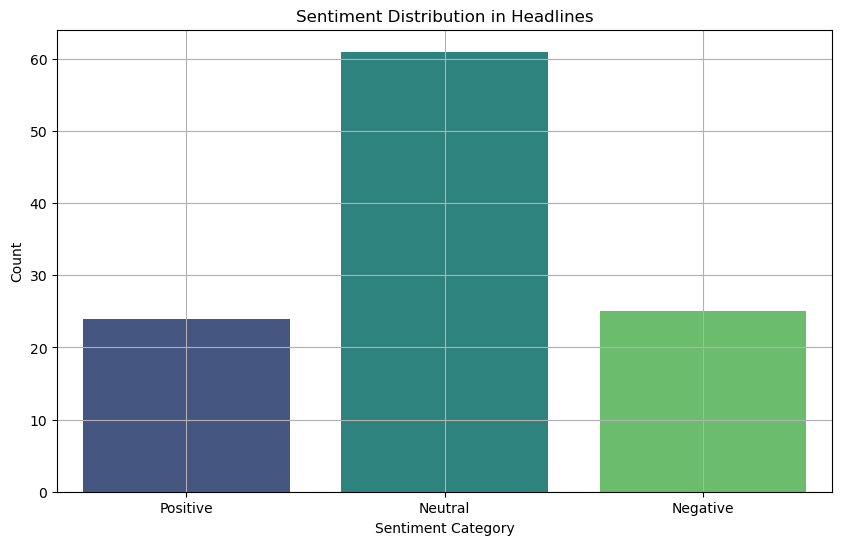

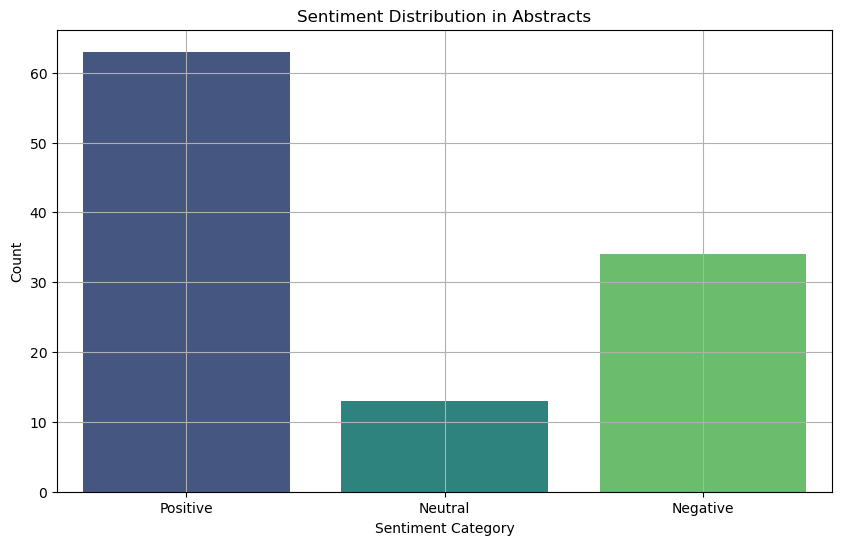

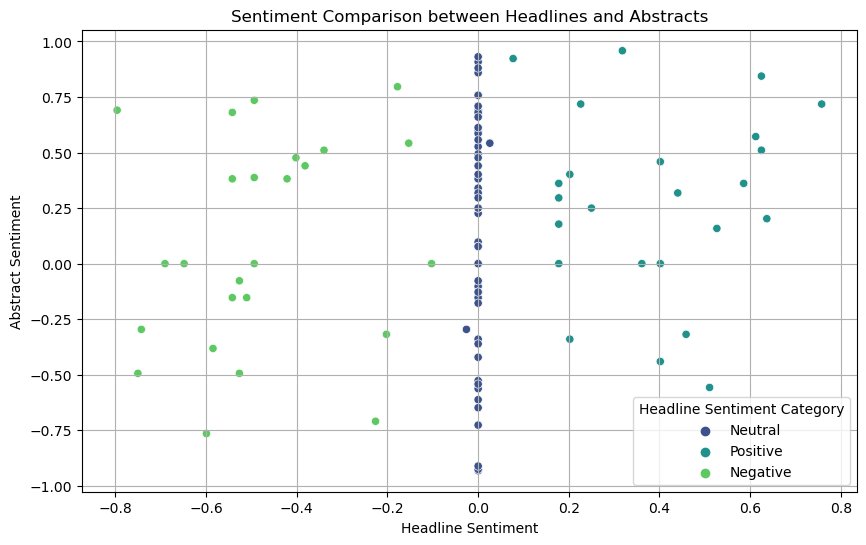

Correlation between headline and abstract sentiments: 0.14793822740916882


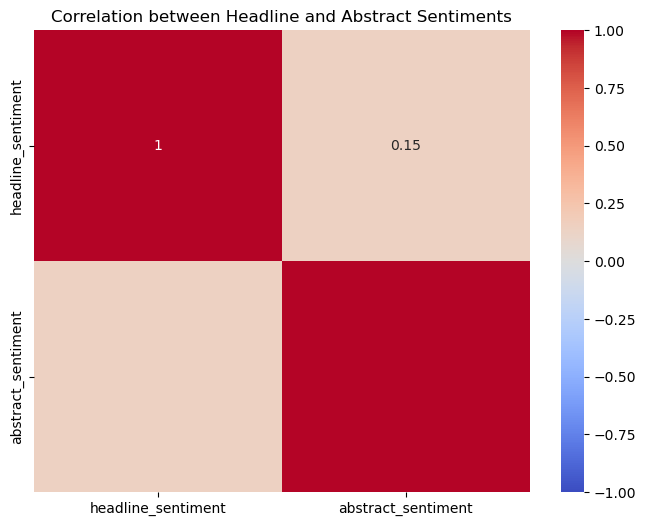

In [12]:
import json

import nltk
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

# Download necessary NLTK data files for sentiment analysis
nltk.download('vader_lexicon')

# Load preprocessed JSON corpus
with open('preprocessed_nyt_articles.json', 'r') as file:
    articles = json.load(file)

# Convert to DataFrame
df = pd.DataFrame(articles)

# Ensure all entries in 'headline' and 'abstract' are strings
df['headline'] = df['headline'].astype(str)
df['abstract'] = df['abstract'].astype(str)

# Fill NaN values in 'abstract' with an empty string
df['abstract'].fillna('', inplace=True)

# Initialize Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis
df['headline_sentiment'] = df['headline'].apply(lambda x: sia.polarity_scores(x)['compound'])
df['abstract_sentiment'] = df['abstract'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Categorize sentiments
def categorize_sentiment(score):
    if score > 0.05:
        return 'Positive'
    elif score < -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['headline_sentiment_category'] = df['headline_sentiment'].apply(categorize_sentiment)
df['abstract_sentiment_category'] = df['abstract_sentiment'].apply(categorize_sentiment)

# Save the processed data to a new file
df.to_csv('processed_nyt_articles.csv', index=False)

print("Sentiment analysis complete. Saved to processed_nyt_articles.csv")
# Load the processed data
df = pd.read_csv('processed_nyt_articles.csv')

# Plot sentiment distribution for headlines
plt.figure(figsize=(10, 6))
sns.countplot(x='headline_sentiment_category', data=df, palette='viridis', order=['Positive', 'Neutral', 'Negative'])
plt.title('Sentiment Distribution in Headlines')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.grid(True)
plt.savefig('headline_sentiment_distribution.png')
plt.show()

# Plot sentiment distribution for abstracts
plt.figure(figsize=(10, 6))
sns.countplot(x='abstract_sentiment_category', data=df, palette='viridis', order=['Positive', 'Neutral', 'Negative'])
plt.title('Sentiment Distribution in Abstracts')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.grid(True)
plt.savefig('abstract_sentiment_distribution.png')
plt.show()
# Scatter plot to show correlation between headline and abstract sentiments
plt.figure(figsize=(10, 6))
sns.scatterplot(x='headline_sentiment', y='abstract_sentiment', data=df, hue='headline_sentiment_category', palette='viridis')
plt.title('Sentiment Comparison between Headlines and Abstracts')
plt.xlabel('Headline Sentiment')
plt.ylabel('Abstract Sentiment')
plt.legend(title='Headline Sentiment Category')
plt.grid(True)
plt.savefig('sentiment_comparison_scatter.png')
plt.show()
# Calculate correlation between headline and abstract sentiments
correlation = df['headline_sentiment'].corr(df['abstract_sentiment'])

# Display correlation result
print(f'Correlation between headline and abstract sentiments: {correlation}')

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(df[['headline_sentiment', 'abstract_sentiment']].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between Headline and Abstract Sentiments')
plt.savefig('sentiment_correlation_heatmap.png')
plt.show()

# Additional Visualisations
With the addition of the dates that discussions and articles were published and its implementation as a field in the JSON data structures we can analyse metrics over time. World clouds can be plotted which signify which words popped up more frequently than others in regards to people's reactions to AI. 

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\natha\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
F:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
F:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Sentiment analysis complete. Saved to processed_nyt_articles.csv


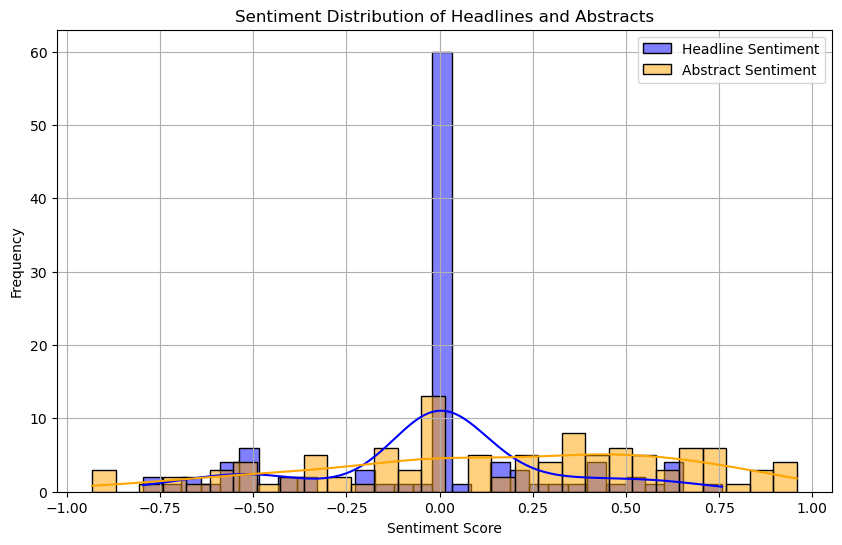

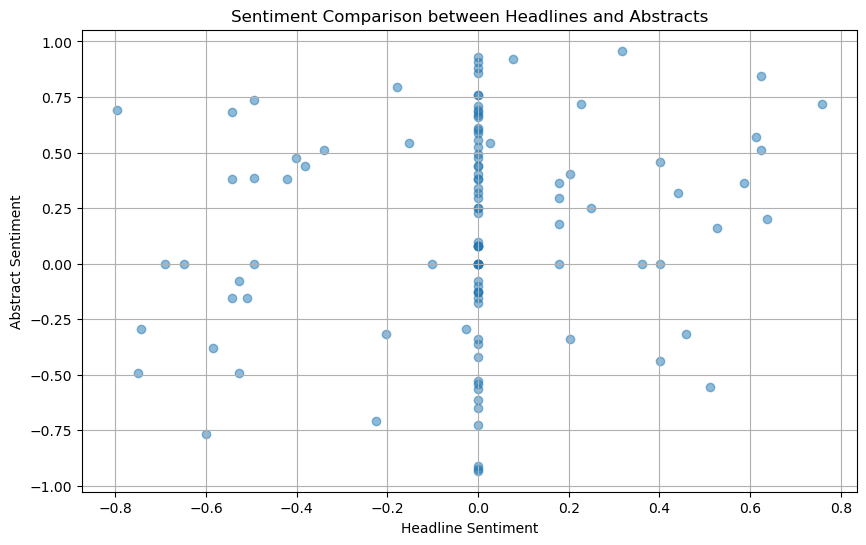

In [13]:
import json
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk

# Download necessary NLTK data files for sentiment analysis
nltk.download('vader_lexicon')

# Load preprocessed JSON corpus
with open('preprocessed_nyt_articles.json', 'r') as file:
    articles = json.load(file)

# Convert to DataFrame
df = pd.DataFrame(articles)

# Ensure all entries in 'headline' and 'abstract' are strings
df['headline'] = df['headline'].astype(str)
df['abstract'] = df['abstract'].astype(str)

# Fill NaN values in 'abstract' with an empty string
df['abstract'].fillna('', inplace=True)

# Initialize Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis
df['headline_sentiment'] = df['headline'].apply(lambda x: sia.polarity_scores(x)['compound'])
df['abstract_sentiment'] = df['abstract'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Save the processed data to a new file
df.to_csv('processed_nyt_articles.csv', index=False)

print("Sentiment analysis complete. Saved to processed_nyt_articles.csv")

# Load the processed data
df = pd.read_csv('processed_nyt_articles.csv')

# Convert publication date to datetime, handle timezone info
df['pub_date'] = pd.to_datetime(df['pub_date']).dt.tz_localize(None)

# Extract year and month
df['year_month'] = df['pub_date'].dt.to_period('M')

# Plot sentiment distributions
plt.figure(figsize=(10, 6))
sns.histplot(df['headline_sentiment'], kde=True, bins=30, color='blue', label='Headline Sentiment')
sns.histplot(df['abstract_sentiment'], kde=True, bins=30, color='orange', label='Abstract Sentiment')
plt.title('Sentiment Distribution of Headlines and Abstracts')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.savefig('sentiment_distribution.png')
plt.show()

# Plot sentiment comparison
plt.figure(figsize=(10, 6))
plt.scatter(df['headline_sentiment'], df['abstract_sentiment'], alpha=0.5)
plt.title('Sentiment Comparison between Headlines and Abstracts')
plt.xlabel('Headline Sentiment')
plt.ylabel('Abstract Sentiment')
plt.grid(True)
plt.savefig('sentiment_comparison.png')
plt.show()





# GitHub Analysis Program
Install TextBlob for Preprocessing and Analysis

In [9]:
import sys
!{sys.executable} -m pip install textblob
!{sys.executable} -m textblob.download_corpora

Finished.


[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\natha\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\natha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\natha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\natha\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\natha\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\natha\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!

# Fetching discussions and its text content from GitHub to store in Discussions.JSON
GitHub API querying with GraphQL to fetch data from many discussion posts and parsing them into specific categories based on what kind of data has been fetched in each discussion. 

In [10]:
import requests
import json
from dotenv import load_dotenv
import os

load_dotenv()
github_token = os.getenv("GITHUB_API_TOKEN")

# Define the GitHub repository owner and name
owner = "ggerganov"
repo = "llama.cpp"
url = "https://api.github.com/graphql"

# GitHub API token
headers = {
    "Authorization": f"Bearer {github_token}",
    "Content-Type": "application/json"
}

# GraphQL query to fetch discussions with pagination
query = """
{
  repository(owner: "%s", name: "%s") {
    discussions(first: 100, after: AFTER_CURSOR) {
      pageInfo {
        endCursor
        hasNextPage
      }
      nodes {
        title
        bodyText
        url
        createdAt
        author {
          login
        }
      }
    }
  }
}
""" % (owner, repo)

# Function to get discussions from the repository
def get_discussions():
    discussions = []
    cursor = None
    while True:
        query_with_cursor = query.replace("AFTER_CURSOR", f'"{cursor}"' if cursor else "null")
        response = requests.post(url, headers=headers, json={'query': query_with_cursor})
        if response.status_code == 200:
            result = response.json()
            nodes = result["data"]["repository"]["discussions"]["nodes"]
            discussions.extend(nodes)
            page_info = result["data"]["repository"]["discussions"]["pageInfo"]
            if page_info["hasNextPage"]:
                cursor = page_info["endCursor"]
            else:
                break
        else:
            raise Exception(f"Query failed with status code {response.status_code}: {response.text}")
    return discussions

# Fetch the discussions
try:
    discussions = get_discussions()

    # Format discussions into a JSON
    discussions_json = json.dumps(discussions, indent=4)

    # Save discussions to a JSON file
    with open("discussions.json", "w") as file:
        file.write(discussions_json)

    print("Discussions have been saved to discussions.json")
except Exception as e:
    print(e)

Discussions have been saved to discussions.json


# Sentiment Analysis of Social Media Platform (GitHub) in regards to AI

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob

# Load data
with open('discussions.json') as f:
    discussions = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(discussions)

# Preview the DataFrame
df.head()

# Sentiment Analysis
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

df['sentiment'] = df['bodyText'].apply(get_sentiment)
df['sentiment_category'] = pd.cut(df['sentiment'], bins=[-1, -0.05, 0.05, 1], labels=['Negative', 'Neutral', 'Positive'])

# Plot Sentiment Distribution
sentiment_counts = df['sentiment_category'].value_counts()

plt.figure(figsize=(10, 6))
sentiment_counts.plot(kind='bar', color=['red', 'grey', 'green'])
plt.title('Sentiment Distribution of AI and Automation Discussions')
plt.xlabel('Sentiment')
plt.ylabel('Number of Discussions')
plt.xticks(rotation=0)
plt.show()


# Engagement Metrics

In [ ]:
# Topic Modeling
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['bodyText'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)


# Example Engagement Metrics
df['comments'] = df['bodyText'].apply(lambda x: len(x.split()))  # Placeholder for actual comments count
df['likes'] = df['bodyText'].apply(lambda x: len(x.split()) // 2)  # Placeholder for actual likes count

# Plot Engagement Metrics
engagement_metrics = df[['comments', 'likes']].sum()

plt.figure(figsize=(10, 6))
engagement_metrics.plot(kind='bar', color=['blue', 'orange'])
plt.title('Engagement Metrics for AI and Automation Discussions')
plt.xlabel('Metric')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Temporal Analysis

In [ ]:
# Temporal Analysis
df['createdAt'] = pd.to_datetime(df['createdAt'])
df.set_index('createdAt', inplace=True)

# Resample to monthly frequency
monthly_mentions = df.resample('M').size()

# Plot Temporal Analysis
plt.figure(figsize=(12, 6))
monthly_mentions.plot(kind='line')
plt.title('Trend of AI and Automation Mentions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Discussions')
plt.show()


# Now that both GitHub and New York Times datasets are processed, they can be visually compared together on the same graphs

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import json

# Function to safely read a JSON file
def safe_read_json(file_path):
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
        df = pd.DataFrame(data)
        return df
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

# Load the datasets
discussions = safe_read_json('discussions.json')
nyt_articles = safe_read_json('nyt_articles.json')

# Check if data was loaded successfully
if discussions is not None and nyt_articles is not None:
    # Convert date columns to datetime
    discussions['createdAt'] = pd.to_datetime(discussions['createdAt'], errors='coerce')
    nyt_articles['pub_date'] = pd.to_datetime(nyt_articles['pub_date'], errors='coerce')

    # Drop rows with invalid dates
    discussions.dropna(subset=['createdAt'], inplace=True)
    nyt_articles.dropna(subset=['pub_date'], inplace=True)

    # Save the total counts before filtering
    total_discussions = discussions.shape[0]
    total_nyt_articles = nyt_articles.shape[0]

    # Filter data to only include entries between March 2023 and May 2024
    start_date = '2023-03-01'
    end_date = '2024-05-01'
    discussions = discussions[(discussions['createdAt'] >= start_date) & (discussions['createdAt'] <= end_date)]
    nyt_articles = nyt_articles[(nyt_articles['pub_date'] >= start_date) & (nyt_articles['pub_date'] <= end_date)]

    # Set the date columns as index
    discussions.set_index('createdAt', inplace=True)
    nyt_articles.set_index('pub_date', inplace=True)

    # Resample to monthly frequency
    monthly_discussions = discussions.resample('M').size()
    monthly_nyt_articles = nyt_articles.resample('M').size()

    # Calculate proportions based on original totals
    monthly_discussions_prop = monthly_discussions / total_discussions
    monthly_nyt_articles_prop = monthly_nyt_articles / total_nyt_articles

    # Calculate moving averages
    discussions_moving_avg = monthly_discussions_prop.rolling(window=3).mean()
    nyt_articles_moving_avg = monthly_nyt_articles_prop.rolling(window=3).mean()

    # Calculate monthly growth rates
    discussions_growth_rate = monthly_discussions_prop.pct_change()
    nyt_articles_growth_rate = monthly_nyt_articles_prop.pct_change()

    # Plot Temporal Analysis
    plt.figure(figsize=(14, 8))

    # Plot proportions
    plt.subplot(2, 1, 1)
    monthly_discussions_prop.plot(kind='line', label='Discussions Proportion', color='blue')
    monthly_nyt_articles_prop.plot(kind='line', label='NYT Articles Proportion', color='orange')
    discussions_moving_avg.plot(kind='line', label='Discussions Moving Avg (3 months)', linestyle='--', color='blue')
    nyt_articles_moving_avg.plot(kind='line', label='NYT Articles Moving Avg (3 months)', linestyle='--', color='orange')
    plt.title('Trend of AI and Automation Mentions Over Time (Proportions) from March 2023 to May 2024')
    plt.xlabel('Date')
    plt.ylabel('Proportion of Discussions/Articles')
    plt.legend()
    plt.grid(True)
    plt.xlim(pd.Timestamp(start_date), pd.Timestamp(end_date))
    plt.ylim(0, max(monthly_discussions_prop.max(), monthly_nyt_articles_prop.max()) * 1.1)

    # Plot growth rates
    plt.subplot(2, 1, 2)
    discussions_growth_rate.plot(kind='line', label='Discussions Growth Rate', color='blue')
    nyt_articles_growth_rate.plot(kind='line', label='NYT Articles Growth Rate', color='orange')
    plt.title('Monthly Growth Rate of AI and Automation Mentions')
    plt.xlabel('Date')
    plt.ylabel('Growth Rate')
    plt.legend()
    plt.grid(True)
    plt.xlim(pd.Timestamp(start_date), pd.Timestamp(end_date))

    # Highlight significant points
    max_discussions_prop_date = monthly_discussions_prop.idxmax()
    max_nyt_articles_prop_date = monthly_nyt_articles_prop.idxmax()

    plt.subplot(2, 1, 1)
    plt.axvline(x=max_discussions_prop_date, color='blue', linestyle='--', alpha=0.7)
    plt.axvline(x=max_nyt_articles_prop_date, color='orange', linestyle='--', alpha=0.7)
    plt.text(max_discussions_prop_date, monthly_discussions_prop.max(), 'Max Discussions', rotation=45, color='blue')
    plt.text(max_nyt_articles_prop_date, monthly_nyt_articles_prop.max(), 'Max NYT Articles', rotation=45, color='orange')

    plt.tight_layout()
    plt.show()
else:
    print("Failed to load one or both datasets.")